# 確率分布の相関検出

## データの準備

In [1]:
# x, yにそれぞれ観測データを準備する。単純オフセット。
import numpy as np
N=10000
Wafer1 = np.random.normal(loc = 0.0, scale = 1.0, size = N)
Wafer2 = np.random.normal(loc = 2.0, scale = 1.0, size = N)

(array([   7.,   96.,  500., 1458., 2591., 2762., 1762.,  663.,  141.,
          20.]),
 array([-1.75591004, -1.02145588, -0.28700171,  0.44745246,  1.18190663,
         1.91636079,  2.65081496,  3.38526913,  4.1197233 ,  4.85417746,
         5.58863163]),
 <a list of 10 Patch objects>)

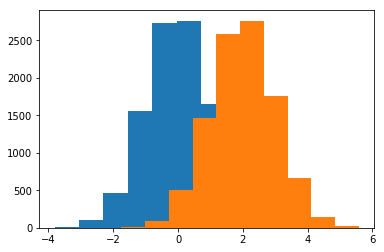

In [2]:
# x, yのヒストグラム
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(Wafer1, bins=10)
plt.hist(Wafer2, bins=10)

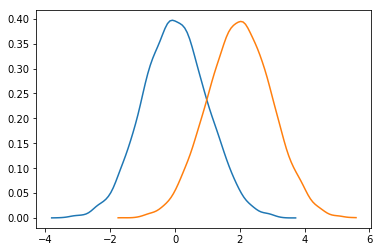

In [3]:
# x, yの確率密度関数(pdf)をプロットする
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
pdf1 = gaussian_kde(Wafer1)
pdf2 = gaussian_kde(Wafer2)
grid1 = np.linspace(min(Wafer1),max(Wafer1),num=100)
grid2 = np.linspace(min(Wafer2),max(Wafer2),num=100)
plt.plot(grid1, pdf1(grid1))
plt.plot(grid2, pdf2(grid2))

## 回帰計算

In [4]:
learning_rate = 0.01

import tensorflow as tf
from scipy.stats import gaussian_kde

def lin_model(X, w, b):
    return tf.add(tf.scalar_mul(w, X), b)

def error_function(prediction, teacher):
    return tf.reduce_mean(tf.square(prediction - teacher))

def f(y):
    return 2*y+1

def wrap_pdf2(y):
    yy = 2*(y.numpy())+1.0
    t =  tf.convert_to_tensor(yy, dtype=tf.float32)
    print(y)
    print(t)
    return t

w = tf.Variable(1.0, name='slope')
b = tf.Variable(1.9, name='offset')

x = tf.constant(Wafer1, dtype=tf.float32)
xpd = tf.constant(pdf1(Wafer1), dtype=tf.float32)
#x = tf.placeholder(tf.float32, shape=(N))
#xpd = tf.placeholder(tf.float32, shape=(N))
y_hypo = lin_model(x, w, b)
with tf.GradientTape() as g:
    g.watch([w,b])
    ypd_hypo = tf.py_function(wrap_pdf2, [y_hypo], tf.float32)
print(g.gradient(ypd_hypo, b))

Instructions for updating:
Colocations handled automatically by placer.


SystemError: <built-in function TFE_Py_TapeWatch> returned a result with an error set

# 参考にしたコード

In [5]:
# 線形回帰の例
# https://qiita.com/TomokIshii/items/f355d8e87d23ee8e0c7a
import numpy as np
import tensorflow as tf


def lin_model(X, w, b):
    return tf.add(tf.scalar_mul(w, X), b)

def error_function(prediction, teacher):
    return tf.reduce_mean(tf.square(prediction - teacher))

w = tf.Variable(0.)
b = tf.Variable(0.)

x = tf.placeholder(tf.float32, shape=(101))
y = tf.placeholder(tf.float32, shape=(101))
y_hypo = lin_model(x, w, b)

#cost = tf.reduce_mean(tf.square(y_hypo - y))
cost = error_function(y_hypo, y)
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

# Initializing
init = tf.global_variables_initializer()

# Train
with tf.Session() as sess:
    trX = np.linspace(-1, 1, 101)
    trY = 2 * trX + 3 + np.random.randn(*trX.shape) * 0.33

    sess.run(init)

    for i in range(1001):
        sess.run(train_step, feed_dict={x: trX, y: trY})
        if i % 100 == 0:
            print("%5d:(w,b)=(%10.4f, %10.4f)" % (i, sess.run(w), sess.run(b)))


    0:(w,b)=(    0.0127,     0.0597)
  100:(w,b)=(    0.9317,     2.5976)
  200:(w,b)=(    1.3962,     2.9341)
  300:(w,b)=(    1.6309,     2.9788)
  400:(w,b)=(    1.7496,     2.9847)
  500:(w,b)=(    1.8096,     2.9855)
  600:(w,b)=(    1.8399,     2.9856)
  700:(w,b)=(    1.8552,     2.9856)
  800:(w,b)=(    1.8629,     2.9856)
  900:(w,b)=(    1.8668,     2.9856)
 1000:(w,b)=(    1.8688,     2.9856)


In [44]:
# python functionのgradientを計算する方法
# https://gist.github.com/harpone/3453185b41d8d985356cbe5e57d67342
import tensorflow as tf
from tensorflow.python.framework import ops
import numpy as np

# Define custom py_func which takes also a grad op as argument:
def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    
    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))
    
    tf.RegisterGradient(rnd_name)(grad)  # see _MySquareGrad for grad example
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)


# Def custom square function using np.square instead of tf.square:
def mysquare(x, name=None):
    # np.square may not be given to py_func directly due to "weak reference" issue.
    def _np_square(x):
        return np.square(x)
    
    with ops.name_scope(name, "Mysquare", [x]) as name:
        sqr_x = py_func(_np_square,
                        [x],
                        [tf.float32],
                        name=name,
                        grad= _MySquareGrad)  # <-- here's the call to the gradient
        return sqr_x[0]

# Actual gradient:
def _MySquareGrad(op, grad):
    x = op.inputs[0]
    return grad * 20 * x  # add a "small" error just to see the difference:


with tf.Session() as sess:
    x = tf.constant([1., 2.])
    y = mysquare(x)
    tf.global_variables_initializer().run()

    print(x.eval(), y.eval(), tf.gradients(y, x)[0].eval())

[1. 2.] [1. 4.] [20. 40.]


In [89]:
def diff(func, x, h = 1e-4):
    return float(((func(x+h)-func(x-h))/h))

c=diff(pdf1, np.array([0,1,2]))
print(pdf1(c, dtype=np.float32))

TypeError: only size-1 arrays can be converted to Python scalars

In [21]:
# python functionのgradientを計算する方法
# https://gist.github.com/harpone/3453185b41d8d985356cbe5e57d67342
import tensorflow as tf
from tensorflow.python.framework import ops
import numpy as np

def diff(func, x, h = 1e-4):
    return float(((func(x+h)-func(x-h))/h))

# Define custom py_func which takes also a grad op as argument:
def py_func(func, inp, Tout, stateful=True, name=None, grad=None):
    
    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))
    
    tf.RegisterGradient(rnd_name)(grad)  # see _MySquareGrad for grad example
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)


# Def custom square function using np.square instead of tf.square:
def mysquare(x, name=None):
    # np.square may not be given to py_func directly due to "weak reference" issue.
    def _np_square(x):
        return np.square(x)
    
    with ops.name_scope(name, "Mysquare", [x]) as name:
        sqr_x = py_func(_np_square,
                        [x],
                        [tf.float32],
                        name=name,
                        grad= _MySquareGrad)  # <-- here's the call to the gradient
        return sqr_x[0]

# Actual gradient:
def _MySquareGrad(op, grad):
    x = op.inputs[0]
    print( x)
    return grad * 2 * x  # add a "small" error just to see the difference:


with tf.Session() as sess:
    x = tf.constant([1., 3.])
    y = mysquare(x)
    tf.global_variables_initializer().run()

    print(x.eval(), y.eval(), tf.gradients(y, x)[0].eval())

Tensor("Const_17:0", shape=(2,), dtype=float32)
[1. 3.] [1. 9.] [2. 6.]
